In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import cv2

import os, itertools, pickle

from util import *
from putil import *
from config import *
%load_ext autoreload
%aimport util
%aimport putil
%aimport config
%autoreload 1

In [11]:
def get_chessboard(frames_dict, board_shape=(7, 9)):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    w, h = board_shape
    objp = np.zeros((w * h, 3), np.float32)
    objp[:, :2] = np.mgrid[:w, :h].T.reshape(-1, 2)
    
    point_dict = {} # maps image_path to (3d point in real world space, 2d point in image plane)
    for image_path, img in sorted(frames_dict.items()):
        gray = clahe.apply(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

        ret, corners = cv2.findChessboardCorners(gray, (w, h))
        if ret:
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
#             corner_img = cv2.drawChessboardCorners(img, (w, h), corners, True)
            print(image_path)
            point_dict[image_path] = (objp, corners)
        else:
            print('no', image_path)
            remove(image_path)
    return point_dict

def filter_nth(matrix, n):
    return np.array(matrix[::n])

In [18]:
# http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
# https://docs.opencv.org/2.4.2/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html

for camera_i in [5]:
    print('camera', camera_i)
    camera_dir = Calibrations + '%s/' % camera_i
    image_dir = camera_dir + 'image/'
    video_dir = camera_dir + 'video/'
    mtx_path = camera_dir + 'camera_matrix.npy'
    dist_path = camera_dir + 'distortion_coefficients.npy'
    
    print('getting camera parameters')
    if os.path.exists(mtx_path) and os.path.exists(dist_path):
        mtx = np.load(mtx_path)
        dist_coef = np.load(dist_path)
    else:
        object_points, image_points = [], []
        for video_name, video_path in list_dir(video_dir, 'mp4', return_name=True):
            point_record = video_path + '.records'
            print('video', video_path)
            if os.path.exists(point_record):
                print('loading saved points')
                point_dict = load_pickle(point_record)
            else:
                print('reading')
                video_name_dir = video_dir + video_name + '/'
                if not os.path.exists(video_name_dir):
                    video_to_frames(video_path, video_name_dir, nth=5)
                video_dict = { image_path : cv2.imread(image_path) for image_path in list_dir(video_name_dir, 'jpg')}
                print('finding points on chessboard for %s frames' % len(video_dict))
                board_shape = (6, 9) if camera_i == 5 else (7, 9)
                point_dict = get_chessboard(video_dict, board_shape=board_shape)
                point_dict = { int(path.split('_')[-1].rstrip('.jpg')) : (path, points) for path, points in point_dict.items() }
                
                filtered_pt_dict = {}
                min_interval = 5
                prev_key = -min_interval
                for key, (path, points) in sorted(point_dict.items()):
                    if key - prev_key >= min_interval:
                        filtered_pt_dict[key] = points
                        prev_key = key
                    else:
                        remove(path)
                point_dict = filtered_pt_dict
                save_pickle(point_dict, point_record)
            for obj_pt, img_pt in point_dict.values():
                object_points.append(obj_pt)
                image_points.append(img_pt)
        if len(object_points) < 25:
            print('not enough matches for camera. Had %s' % len(object_points))
            continue
        else:
            print('found %s matches for camera' % len(object_points))
        
        ret, mtx, dist_coef, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, (Video_width, Video_height), None, None, flags=cv2.CALIB_RATIONAL_MODEL)
        
        np.save(mtx_path, mtx)
        np.save(dist_path, dist_coef)
        
        total_error = 0
        for i in range(len(object_points)):
            image_points2, _ = cv2.projectPoints(object_points[i], rvecs[i], tvecs[i], mtx, dist_coef)
            error = cv2.norm(image_points[i], image_points2, cv2.NORM_L2) / len(image_points2)
            total_error += error
        print('mean error:', total_error / len(object_points))
        
    print('getting new camera matrix')
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist_coef, (Video_width, Video_height), 0)
    if not any(roi):
        print('zeros for roi')
        continue
    print('generated new camera matrix')
    output_dir = make_dir(camera_dir + 'output/')
    for v_name, v_path in list_dir(camera_dir + 'test/', 'mp4', return_name=True):
        print('testing', v_path)
        shell('python undistort.py %s %s %s' % (v_path, camera_dir, output_dir + v_name + '.mp4'))
print('done')

camera 5
getting camera parameters
getting new camera matrix
generated new camera matrix
testing /mnt/c/Users/zhong/Desktop/bdd/calibrations/5/test/test.mp4
done


In [20]:
# http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
# https://docs.opencv.org/2.4.2/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

def display_calibration_boards(camera_i):
    print('camera', camera_i)
    camera_dir = Calibrations + '%s/' % camera_i
    image_dir = camera_dir + 'image/'
    video_dir = camera_dir + 'video/'
    mtx_path = camera_dir + 'camera_matrix.npy'
    dist_path = camera_dir + 'distortion_coefficients.npy'
    
    mtx = np.load(mtx_path)
    dist_coef = np.load(dist_path)
    object_points, image_points = [], []
    for video_name, video_path in list_dir(video_dir, 'mp4', return_name=True):
        point_dict = load_pickle(video_path + '.records')
        for obj_pt, img_pt in point_dict.values():
            object_points.append(obj_pt)
            image_points.append(img_pt)
    ret, mtx, dist_coef, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, (V_w, V_h), None, None, flags=cv2.CALIB_RATIONAL_MODEL)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter([0], [0], [0], c='black')
    for obj_pt_set, img_pt_set, rvec, tvec in zip(object_points, image_points, rvecs, tvecs):
        R, _ = cv2.Rodrigues(rvec)
        xs, ys, zs = np.dot(R, obj_pt_set.T) + tvec
        ax.scatter(xs, ys, zs, s=1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

camera 1


<IPython.core.display.Javascript object>


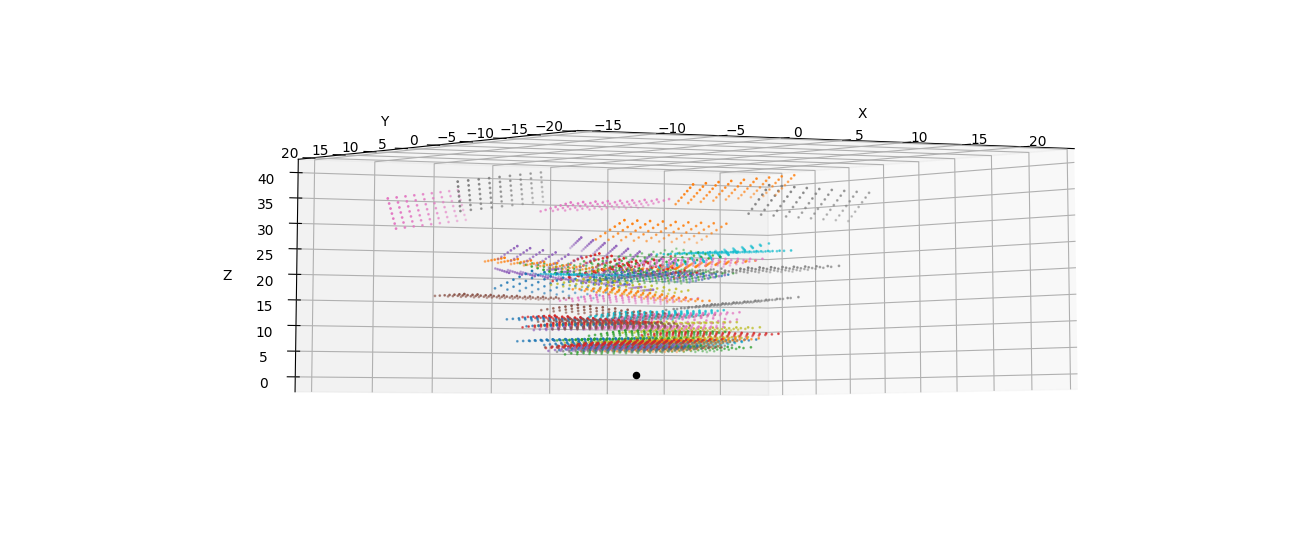

In [21]:
display_calibration_boards(1)

camera 2


<IPython.core.display.Javascript object>


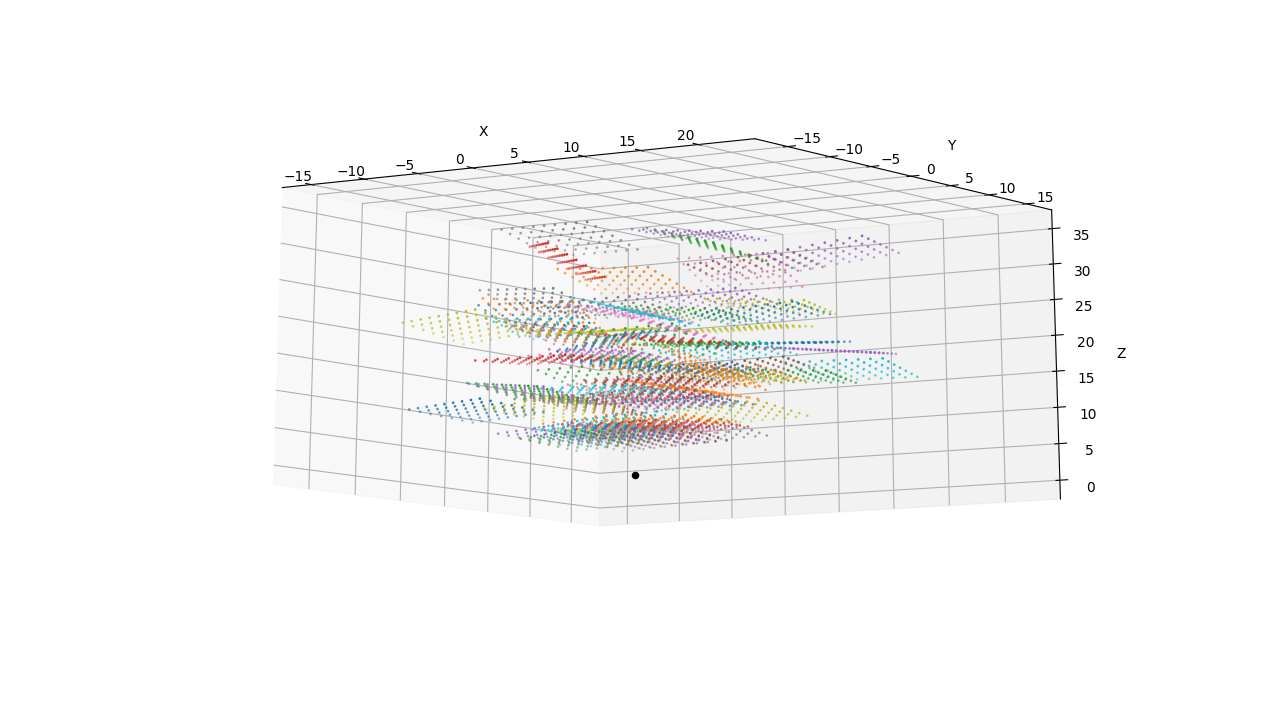

In [22]:
display_calibration_boards(2)

camera 3


<IPython.core.display.Javascript object>


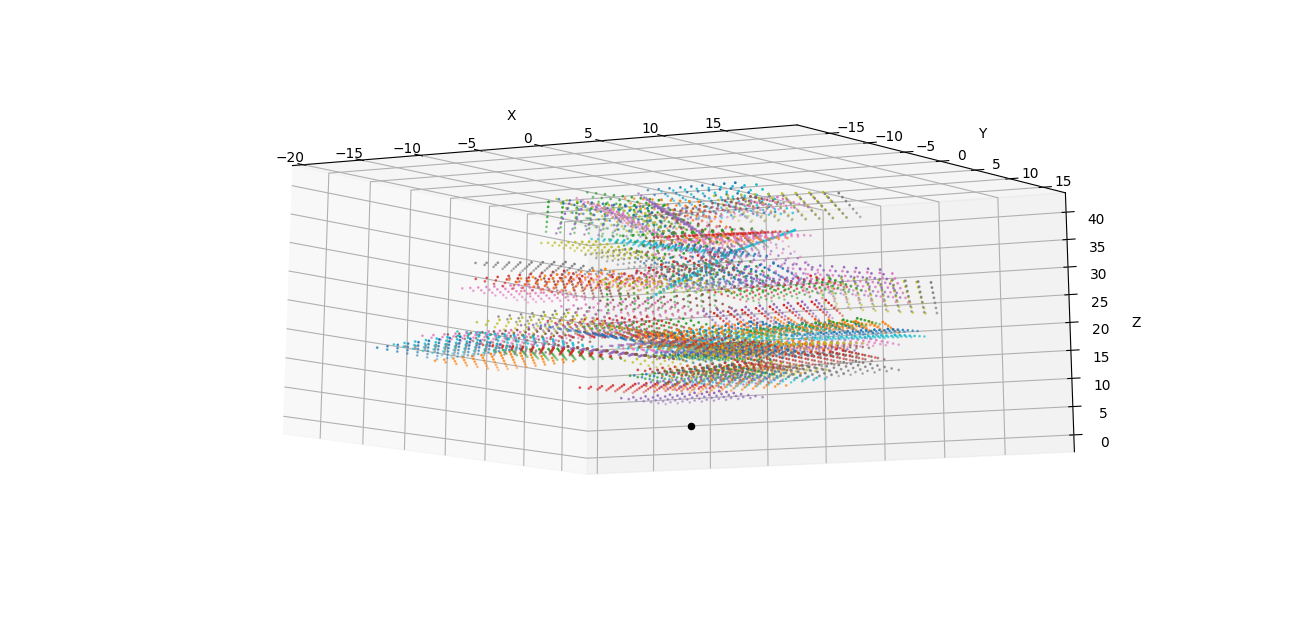

In [23]:
display_calibration_boards(3)

camera 4


<IPython.core.display.Javascript object>


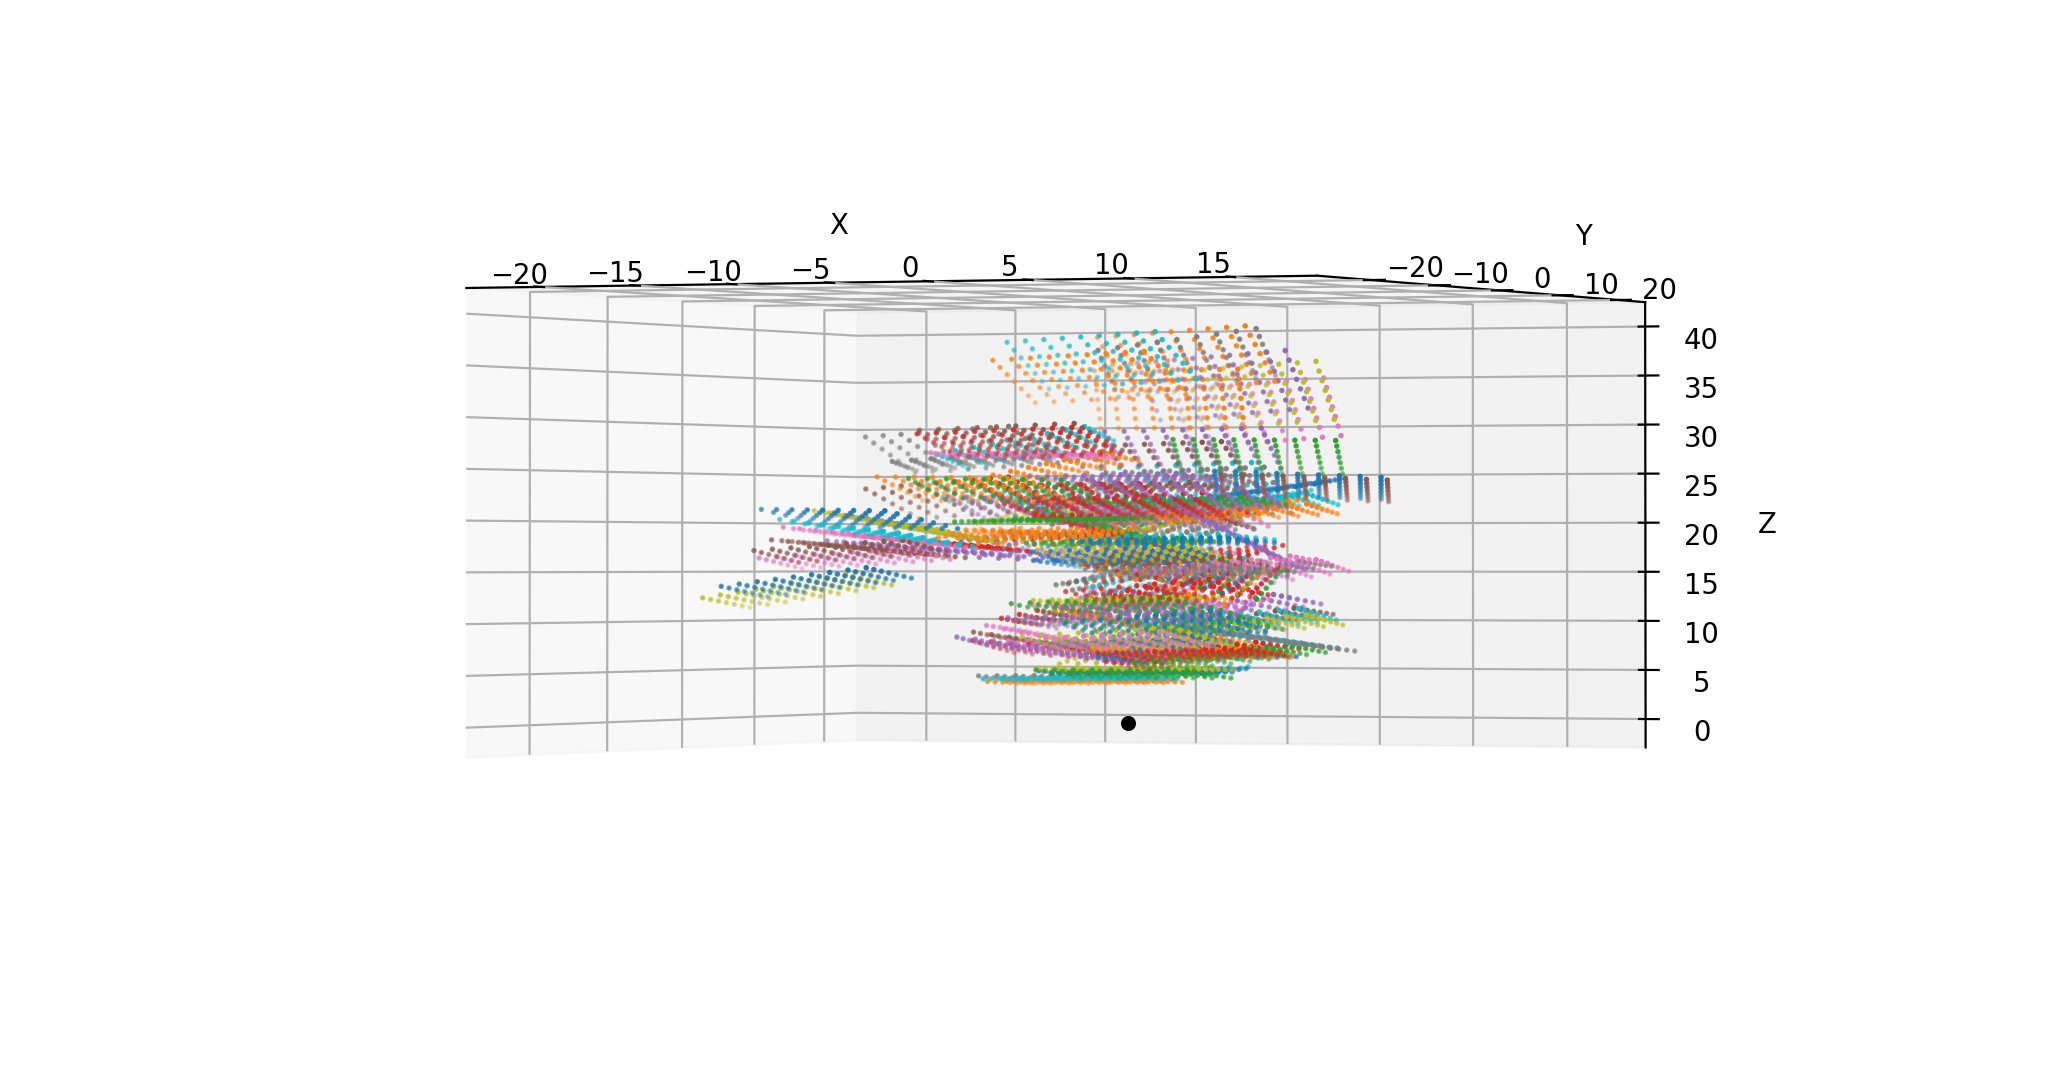

In [24]:
display_calibration_boards(4)

camera 5


<IPython.core.display.Javascript object>


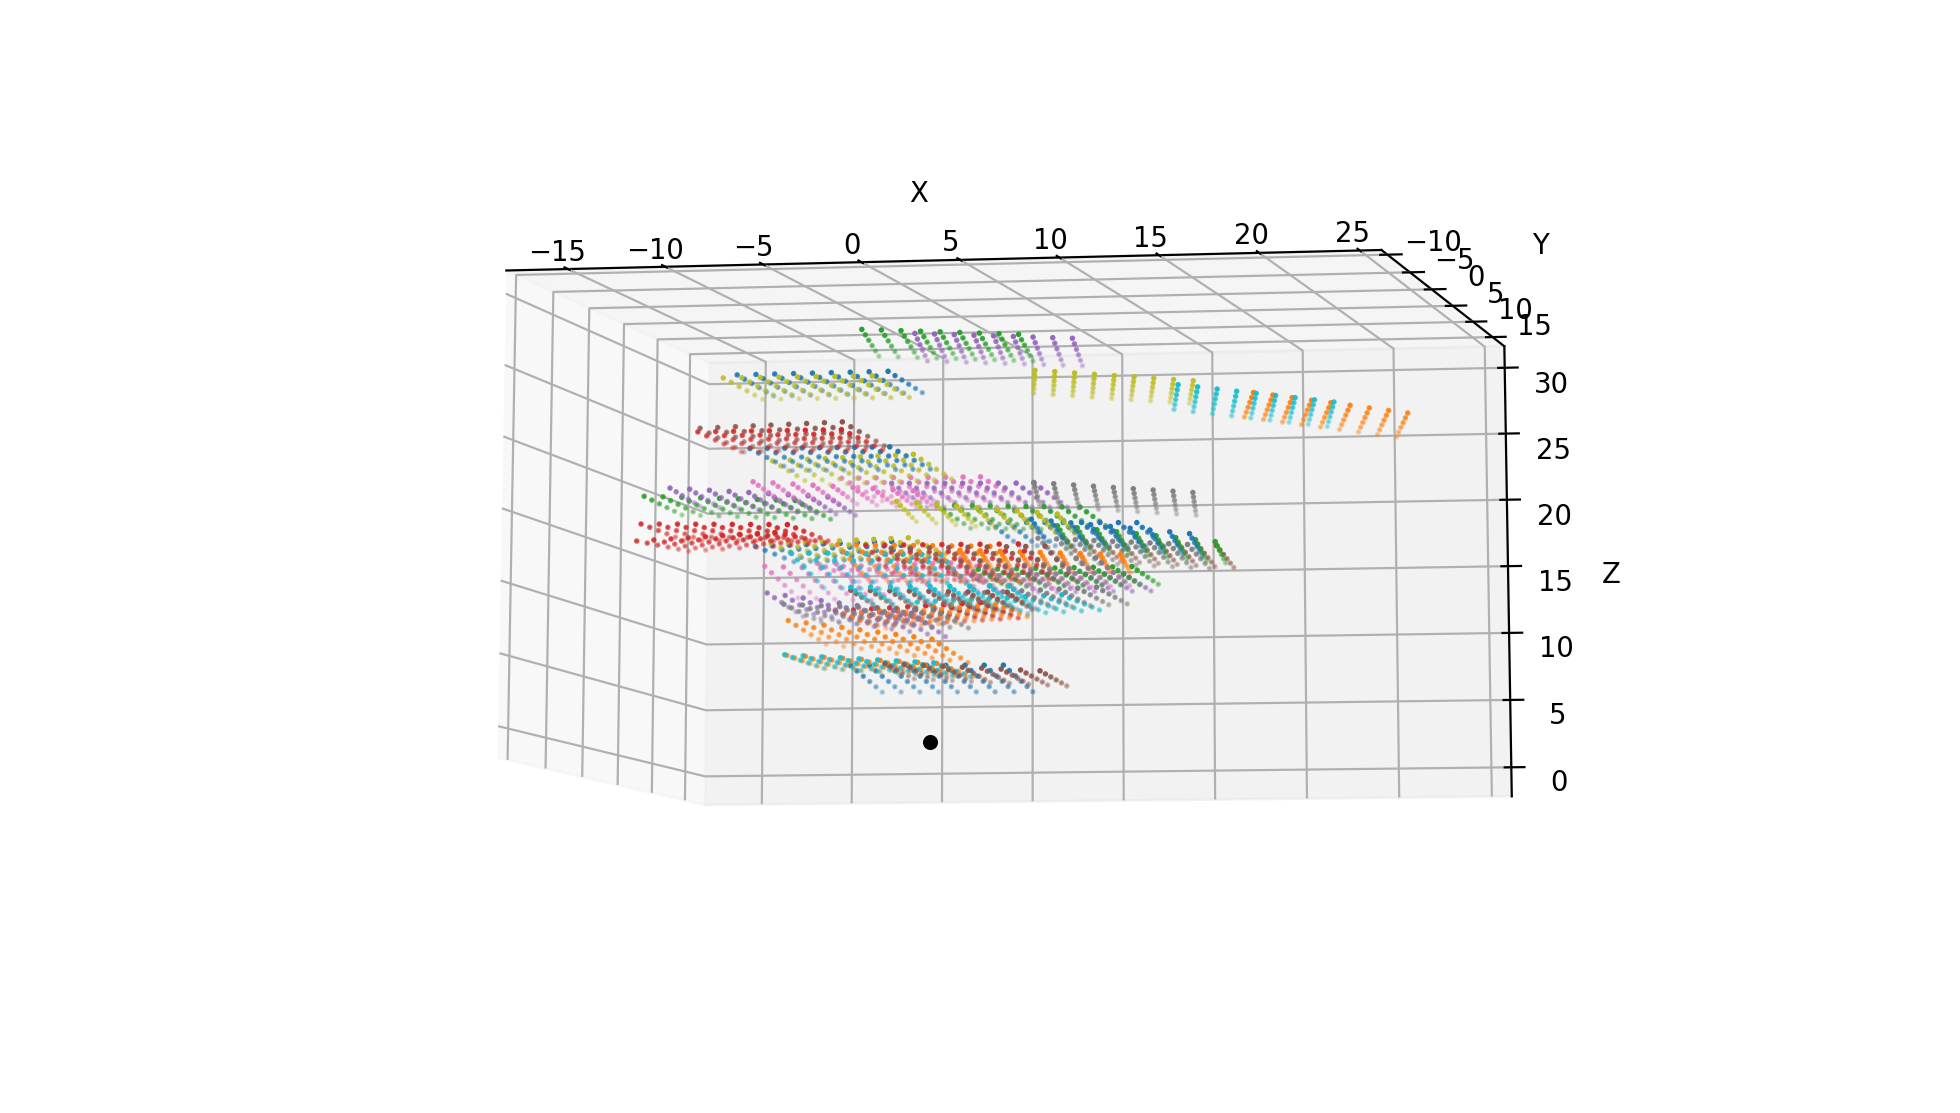

In [25]:
display_calibration_boards(5)

camera 6


<IPython.core.display.Javascript object>


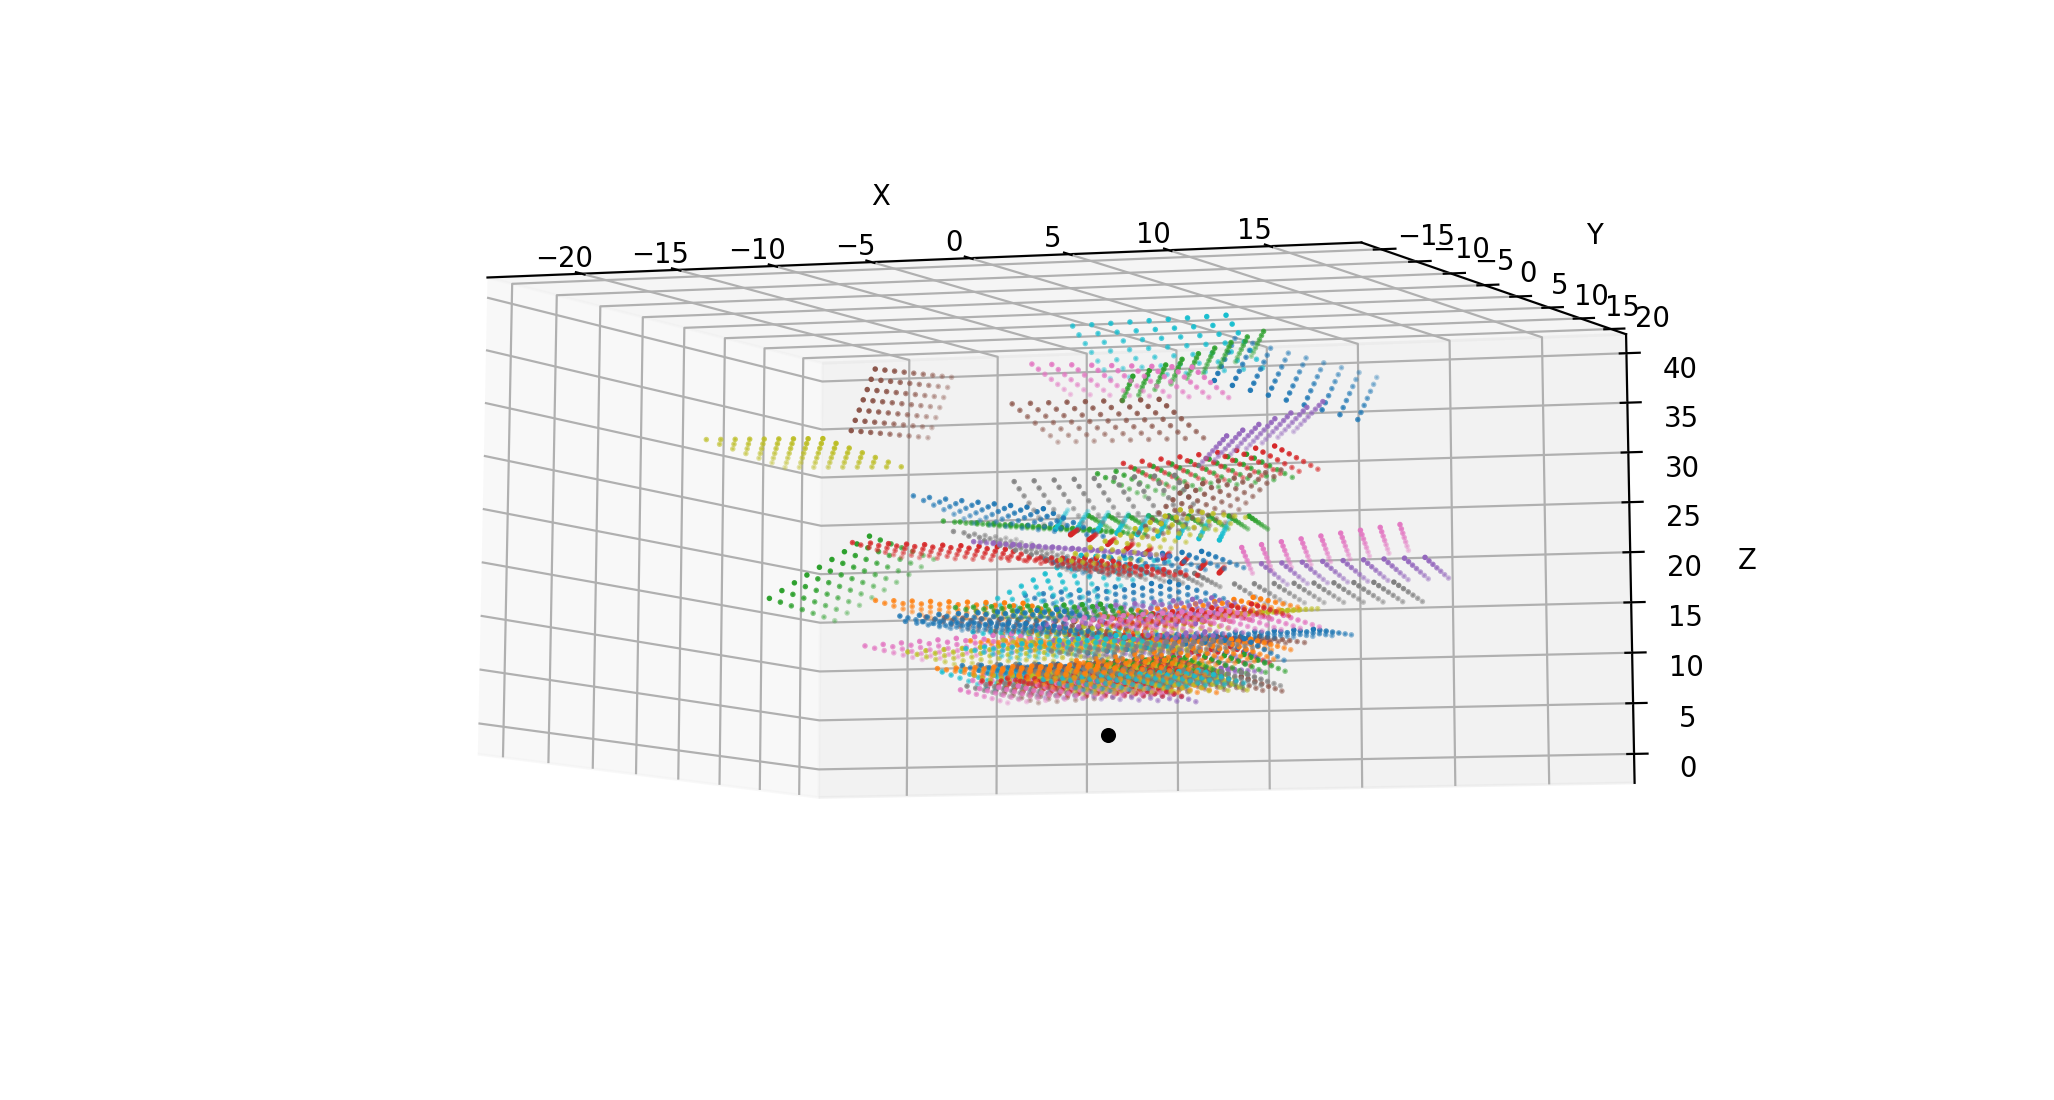

In [26]:
display_calibration_boards(6)